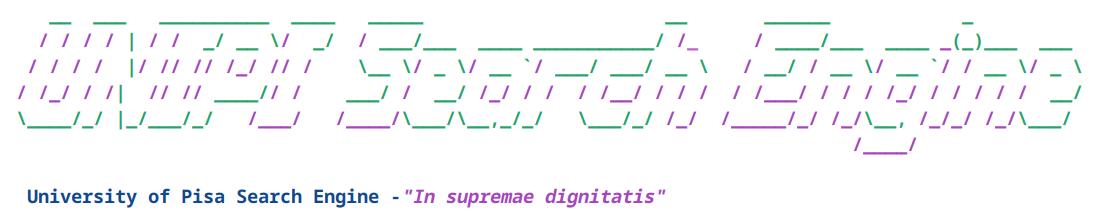

This notebook is created for the course [MULTIMEDIA INFORMATION RETRIEVAL AND COMPUTER VISION](https://unipi.coursecatalogue.cineca.it/insegnamenti/2024/51012_683528_76087/2021/51012/11227?coorte=2023&schemaid=8694) for the academic year 2024/2025.


**Authors:** Asadnia Ali - Cherchi Noemi - Colak Feyzan - Temfack Derick

**Examiner**: Prof. NICOLA TONELLOTTO

**Program:** Masters Degree in [Artificial Intelligence and Data Engineering](https://computer.ing.unipi.it/aide-lm)

# Goal of the Project

This project focuses on developing a comprehensive search engine tailored to the University of Pisa, incorporating all the theoretical and practical concepts covered during the course lectures. The project will implement a complete information retrieval pipeline, starting with web crawling of the University of Pisa's online resources. This will be followed by indexing the collected data to enable efficient search capabilities, designing robust querying mechanisms, and conducting a an evaluation of the search engine's performance and relevance. The ultimate goal is to deliver a functional and effective tool that exemplifies the principles of modern search engine technology while serving the university's needs.

# Setup

## Install Dependencies

In [2]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=d3e0ce6422c9f35bed15aee355aaf9ce5ca7d48271428e9598abb6835cc4623c
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


## Download the data collections

In [3]:
# Download the collection
!wget -O documents.tar.xz https://github.com/noemichem/Bravehearts1/raw/refs/heads/main/data/documents.tar.xz

# Unzip the collection
!tar -xJvf documents.tar.xz


--2024-12-19 16:17:43--  https://github.com/noemichem/Bravehearts1/raw/refs/heads/main/data/documents.tar.xz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/noemichem/Bravehearts1/refs/heads/main/data/documents.tar.xz [following]
--2024-12-19 16:17:43--  https://raw.githubusercontent.com/noemichem/Bravehearts1/refs/heads/main/data/documents.tar.xz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6776516 (6.5M) [application/octet-stream]
Saving to: ‘documents.tar.xz’

documents.tar.xz    100%[===================>]   6.46M  --.-KB/s    in 0.09s   

2024-12-19 16:17:44 (68.4 MB/s) - ‘documents.tar.x

# Utils classes

In this section, we are defining our utilities classes containing methods such as:
- Preprocessing data (lowercase, tokenization, stop words removal, stemming, etc)
- Profiling to calculate the running time of a function
- Save and load the inverted index

In [4]:
import json
import pickle
import re
import string
import time
import nltk

from pathlib import Path
from typing import List
from langdetect import detect
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Download the stopwords
nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)
nltk.download("stopwords", quiet=True)


class Preprocessor:

    @staticmethod
    def preprocess(text: str, lang: str = "english") -> List[str]:

        if lang == "all":
            tmp_lang = detect(text)
            lang = "english" if tmp_lang == "en" else "italian"

        if lang not in stopwords.fileids():
            raise ValueError(
                f"Language '{lang}' is not supported. The language \
                should be one of the following: {stopwords.fileids()}"
            )

        # Lowercase the text
        text = text.lower()

        # Replace ampersand with 'and'
        text = text.replace("&", " and ")

        # Normalize special characters (smart quotes, dashes, etc.)
        text = text.translate(str.maketrans("‘’´“”–-", "'''\"\"--"))

        # Remove unnecessary periods in acronyms
        text = re.sub(r"\.(?!(\S[^. ])|\d)", "", text)

        # Remove punctuation and replace with spaces
        text = text.translate(
            str.maketrans(string.punctuation, " " * len(string.punctuation))
        )

        # Tokenize using NLTK (language aware)
        tokens = word_tokenize(text, language=lang)

        # Remove stopwords for the given language
        stop_words = set(stopwords.words(lang))
        tokens = [word for word in tokens if word not in stop_words]

        # Stemming
        stemmer = SnowballStemmer(lang)

        # Stem the tokens
        tokens = [stemmer.stem(token) for token in tokens]

        return tokens

    @staticmethod
    def profile(f):
        def f_timer(*args, **kwargs):
            start = time.time()
            result = f(*args, **kwargs)
            end = time.time()
            elapsed_time = end - start

            if elapsed_time >= 60:  # If the time is more than a minute
                minutes = int(elapsed_time // 60)
                seconds = elapsed_time % 60
                print(f"{f.__name__}: {minutes} min {seconds:.3f} s")
            elif elapsed_time >= 1:  # If the time is more than a second
                print(f"{f.__name__}: {elapsed_time:.3f} s")
            else:  # If the time is less than a second
                print(f"{f.__name__}: {elapsed_time * 1000:.3f} ms")

            return result

        return f_timer


class InvertedIndexManager:

    @staticmethod
    def load_index(input_file: str):

        input_file_path = Path(input_file)
        if not input_file_path.exists():
            raise ValueError(
                f"Input file {input_file} does not exist.\
                     Make sure the path is correct."
            )

        if not input_file_path.is_file():
            raise ValueError(
                f"Input file {input_file} is not a file. \
                    Make sure to provide a file as input."
            )

        # Load the index from the pickle file
        with open(input_file_path, "rb") as f:
            lexicon, inv, doc_index, stats = pickle.load(f)

        return lexicon, inv, doc_index, stats

    @staticmethod
    def save_index(
        output_folder_path: Path,
        lexicon: dict,
        inv_d: dict,
        inv_f: dict,
        doc_index: list,
        stats: dict,
    ):

        # Save the results as pickle files
        with open(f"{output_folder_path}/index.pkl", "wb") as f:
            pickle.dump(
                (lexicon, {"docids": inv_d, "freqs": inv_f}, doc_index, stats),
                f,
            )

        # Save each part to a separate JSONL file
        with open(
            f"{output_folder_path}/lexicon.json", "w", encoding="utf-8"
        ) as lex_file:
            lex_file.write(json.dumps(lexicon))

        with open(
            f"{output_folder_path}/inverted_file.jsonl", "w", encoding="utf-8"
        ) as inv_file:
            inv_file.write(json.dumps({"docids": inv_d, "freqs": inv_f}))

        with open(
            f"{output_folder_path}/doc_index.jsonl", "w", encoding="utf-8"
        ) as doc_file:
            doc_file.write(json.dumps(doc_index, ensure_ascii=False))

        with open(
            f"{output_folder_path}/stats.json", "w", encoding="utf-8"
        ) as stats_file:
            json.dump(stats, stats_file, ensure_ascii=False, indent=4)


In [5]:
text = "This is a sample text for testing the preprocessor function."
tokens = Preprocessor.preprocess(text, lang="all")
print(tokens)

['sampl', 'text', 'test', 'preprocessor', 'function']


# Indexing

In this section, we are defining the code necessary to build our inverted index and save it on the disk.

In [6]:
import json
from collections import Counter, defaultdict
from pathlib import Path
from typing import Literal

from tqdm.auto import tqdm


class Indexing:

    def __init__(
        self,
        input_folder: str,
        output_folder: str,
        lang: Literal["en", "it", "all"],  # noqa
    ) -> None:

        input_folder_path = Path(input_folder)
        if not input_folder_path.exists():
            raise ValueError(
                f"Input folder {input_folder} does not exist.\
                     Make sure the path is correct."
            )

        if not input_folder_path.is_dir():
            raise ValueError(
                f"Input folder {input_folder} is not a directory. \
                    Make sure to provide a directory as input."
            )

        # Get all files that end with .jsonl
        jsonl_files = list(input_folder_path.glob("*.jsonl"))

        if len(jsonl_files) == 0:
            raise ValueError(
                f"No .jsonl files found in the input folder {input_folder}. \
                    Make sure to provide a folder with .jsonl files."
            )

        # Filter files based on language
        if lang != "all":
            self.lang = "english" if lang == "en" else "italian"
            jsonl_files = [
                file for file in jsonl_files if f".{lang}" in file.suffixes[1:]
            ]
        else:
            self.lang = "all"

        self.input_folder = input_folder
        self.output_folder = output_folder
        self.input_files = jsonl_files

        # Initialize data structures
        # "term": [docid, doc_freq, col_freq] where doc_freq is the number of
        # documents in which the term appears and col_freq is the total number
        # of times the term appears in the collection
        self.lexicon = {}
        self.doc_index = {}  # Document index
        self.inv_d = defaultdict(list)  # TermID to list of DocIDs
        # TermID to list of term frequencies in each DocID
        self.inv_f = defaultdict(list)
        self.termid = 0  # TermID counter

        self.num_docs = 0  # Number of documents
        self.total_dl = 0  # Total document length
        self.total_toks = 0  # Total number of tokens

    @Preprocessor.profile
    def build_index(self):

        # Create the output folder if it does not exist
        output_folder_path = Path(self.output_folder)
        if not output_folder_path.exists():
            output_folder_path.mkdir(parents=True)

        for fileid, file in tqdm(
            enumerate(self.input_files),
            desc="Indexing Files",
            total=len(self.input_files),
        ):
            # Open and read the JSONL file
            with open(file, "r", encoding="utf-8") as file_content:
                for line in file_content:
                    doc = json.loads(line)  # Parse JSON line
                    # Assign a new docid incrementally
                    docid = len(self.doc_index)
                    # Tokenize and preprocess text
                    tokens = Preprocessor.preprocess(doc["text"], self.lang)
                    # Count term frequencies in the document
                    token_tf = Counter(tokens)

                    # Update lexicon, inverted file, and document index
                    for token, tf in token_tf.items():
                        # Add term to lexicon if not already present
                        if token not in self.lexicon:
                            # [termid, doc_freq, col_freq] i.e. termid is the term identifier, # noqa
                            #  doc_freq is the number of documents in which the term appears, # noqa
                            # and col_freq is the total number of times the term appears in the # noqa
                            # collection
                            self.lexicon[token] = [
                                self.termid,
                                0,
                                0,
                            ]
                            # Initialize posting lists
                            self.inv_d[self.termid], self.inv_f[self.termid] = (  # noqa
                                [],
                                [],
                            )  # noqa
                            self.termid += 1  # Increment termid

                        # Update posting lists and term frequency
                        token_id = self.lexicon[token][0]  # Get termid
                        # Add docid to posting list
                        self.inv_d[token_id].append(docid)
                        # Add term frequency in posting list
                        self.inv_f[token_id].append(tf)
                        # Increment document frequency i.e the number of
                        # documents in which the term appears
                        self.lexicon[token][1] += 1
                        # Increment collection frequency i.e the total
                        # number of times the term appears in the collection
                        self.lexicon[token][2] += tf

                    # Update document index
                    doclen = len(tokens)  # Document length
                    self.doc_index[docid] = {
                        "doclen": doclen,
                        "url": doc["url"],
                        "title": doc["title"],
                    }
                    self.total_dl += doclen
                    self.num_docs += 1

        # Properties file with collection statistics
        stats = {
            "num_docs": len(self.doc_index),
            "num_terms": len(self.lexicon),
            "total_tokens": self.total_dl,
        }

        InvertedIndexManager.save_index(
            output_folder_path=output_folder_path,
            lexicon=self.lexicon,
            inv_d=self.inv_d,
            inv_f=self.inv_f,
            doc_index=self.doc_index,
            stats=stats,
        )

        return self.lexicon, {"docids": self.inv_d, "freqs": self.inv_f}, self.doc_index, stats


In [7]:
input_folder = "/content/documents"  # Replace with your actual input folder path
output_folder = "/content/index"  # Replace with your actual output folder path
lang = "all"  # Set language as "en", "it", or "all"

# Instantiate and run the Indexing class
indexer = Indexing(input_folder, output_folder, lang)
lexicon, inv, doc_index, stats = indexer.build_index()

Indexing Files:   0%|          | 0/34 [00:00<?, ?it/s]

build_index: 16 min 28.695 s


In [8]:
print("Statistics")
print(stats)

Statistics
{'num_docs': 27306, 'num_terms': 75855, 'total_tokens': 11134184}


## TODO: Download the inverted Index from external source

# Querying

After building our inverted index, we are ready to start implementing different retrieval methodologies.

## Querying Interface

This section define the code to instance a search UI interface. It will be usefull in the upcomming sections to visually test our search engine through a search interface after implementing scoring functions like TF-IDF, BM25, etc.

In [6]:
import pandas as pd
from ipywidgets import widgets, Output, VBox, HBox, Layout
from IPython.display import display, clear_output, HTML

def create_hyperlinked_dataframe(df):
    """
    Convert 'url' column in the DataFrame into clickable hyperlinks.

    Parameters:
        df (pd.DataFrame): DataFrame containing a 'url' column.

    Returns:
        HTML: HTML representation of the DataFrame with clickable links.
    """
    # Check if 'url' column exists
    if 'url' in df.columns:
        df['url'] = df['url'].apply(
            lambda x: f'<a href="{x}" target="_blank" style="color: #1E90FF; text-decoration: none;">{x}</a>'
        )
    return HTML(df.to_html(escape=False, index=False))

def process_query(query, method, query_processor, output_area):
    """
    Function to process the query based on the selected method.

    Parameters:
        query (str): The user query.
        method (str): The processing method ("DAAT" or "TAAT").
        output_area: The output widget for displaying results.
    """
    with output_area:
        clear_output()  # Clear previous output
        print(f"\nProcessing with {method}...")

        try:
            # Process the query based on the selected method
            if method == "DAAT":
                results = query_processor.query_process_daat(query)
            elif method == "TAAT":
                results = query_processor.query_process_taat(query)

            # Display results
            if not results:
                print("\nNo results found for the query.")
            else:
                df = pd.DataFrame(results)
                # Create hyperlinked DataFrame
                display(HTML("<h4>Search Results:</h4>"))
                display(create_hyperlinked_dataframe(df))
        except Exception as e:
            print(f"An error occurred: {e}")

def search_engine_ui(query_processor):
    """
    Interactive UI for the search engine with Enter key support.
    """
    # Dropdown to select the processing method
    method_dropdown = widgets.Dropdown(
        options=["DAAT", "TAAT"],
        value="DAAT",
        description="Method:",
        layout=Layout(width='30%')
    )

    # Text box for the query input
    query_input = widgets.Text(
        value='',
        placeholder='Enter your query',
        description='Query:',
        layout=Layout(width='70%')
    )

    # Button to process the query
    search_button = widgets.Button(
        description="Search",
        button_style='success',  # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Click to search',
        icon='search',
        layout=Layout(width='20%')
    )

    # Output area to display results
    # output_area = Output(layout=Layout(border='1px solid lightgray', width='100%', height='auto'))
    output_area = Output(layout=Layout(width='100%', height='auto'))

    # Event handler for the search button
    def on_search_clicked(b=None):
        query = query_input.value.strip()
        method = method_dropdown.value

        if not query:
            with output_area:
                clear_output()
                print("Please enter a query.")
            return

        # Process the query
        process_query(query, method, query_processor, output_area)

    # Link the button click event to the handler
    search_button.on_click(on_search_clicked)

    # Add "Enter key" support for query input
    query_input.on_submit(on_search_clicked)

    # Layout for input elements
    input_area = HBox([query_input, method_dropdown, search_button])

    # Full layout
    ui = VBox([input_area, output_area], layout=Layout(width='100%'))

    # Display the UI
    display(ui)


## Generic Inverted Index and Generic Query Processor

We will explore the querying process by experimenting with different scoring functions, such as TF-IDF and BM25. Since transitioning from one scoring function to another requires only minor modifications to the code, we will apply the **DRY (Don't Repeat Yourself) Principle**. This means we will consolidate the common code into a generic class and use inheritance to implement specific behaviors.

### Generic Inverted Index

This is a generic class that represents an inverted index. In the upcoming section, we will create specialized classes, such as BM25InvertedIndex, which will inherit from this class. For example, the BM25InvertedIndex will implement specific behaviors for BM25 while utilizing the reusable methods and functionality provided by this generic class.

In [7]:
import heapq
import math

class GenericInvertedIndex:

    def __init__(self, lex, inv, doc, stats):
        self.lexicon = lex
        self.inv = inv
        self.doc = doc
        self.stats = stats

    def num_docs(self):
        return self.stats["num_docs"]

    def get_posting(self, termid):
       return GenericInvertedIndex.PostingListIterator(
            self.inv["docids"][termid], self.inv["freqs"][termid], self.doc
        )


    def get_termids(self, tokens):
        return [
            self.lexicon[token][0] for token in tokens if token in self.lexicon
        ]  # noqa

    def get_postings(self, termids):
        return [self.get_posting(termid) for termid in termids]


    class PostingListIterator:
        def __init__(self, docids, freqs, doc):
            """
            Initialize the PostingListIterator.

            Parameters:
                docids (list): List of document IDs where the term appears.
                freqs (list): List of term frequencies in the corresponding documents.
                doc (dict): Document index with metadata for each document.
                doc_freq (int): Document frequency of the term.
                total_docs (int): Total number of documents in the collection.
            """
            self.docids = docids
            self.freqs = freqs
            self.pos = 0
            self.doc = doc

        def docid(self):
            if self.is_end_list():
                return math.inf
            return self.docids[self.pos]

        def score(self):
            if self.is_end_list():
                return math.inf
            return self.freqs[self.pos] / self.doc[self.docid()]["doclen"]

        def next(self, target=None):
            if not target:
                if not self.is_end_list():
                    self.pos += 1
            else:
                if target > self.docids():
                    try:
                        self.pos = self.docids.index(target, self.pos)
                    except ValueError:
                        self.pos = len(self.docids)

        def is_end_list(self):
            return self.pos == len(self.docids)

        def len(self):
            return len(self.docids)

### Generic Querying Processor

The QueryProcessor class is designed to handle the execution of queries using TAAT (Term-at-a-Time) and DAAT (Document-at-a-Time) algorithms. It achieves this by loading the appropriate inverted index and providing methods to process these algorithms effectively.

Since each subclass of GenericInvertedIndex requires specific handling for its algorithms, we introduce a GenericQueryProcessor class. This generic class is responsible for loading a GenericInvertedIndex and provides reusable methods for query processing.

Subsequent QueryProcessor subclasses will inherit from GenericQueryProcessor. They will focus on loading the specific type of inverted index required for their use case (e.g., a BM25 inverted index) while reusing the methods in the parent class, avoiding redundant code implementation. This structure ensures clarity, modularity, and efficiency in the design.

In [8]:
import math
from collections import defaultdict
import pandas as pd

class TopQueue:
    def __init__(self, k=10, threshold=0.0):
        self.queue = []
        self.k = k
        self.threshold = threshold

    def size(self):
        return len(self.queue)

    def would_enter(self, score):
        return score > self.threshold

    def clear(self, new_threshold=None):
        self.queue = []
        if new_threshold:
            self.threshold = new_threshold

    def __repr__(self):
        return f"<{self.size()} items, th={self.threshold} {self.queue}"

    def insert(self, docid, score):
        if score > self.threshold:
            if self.size() >= self.k:
                heapq.heapreplace(self.queue, (score, docid))
            else:
                heapq.heappush(self.queue, (score, docid))
            if self.size() >= self.k:
                self.threshold = max(self.threshold, self.queue[0][0])
            return True
        return False

class GenericQueryProcessor:

    def __init__(self, index_file):
        self.lex, self.inv, self.doc, self.stats = InvertedIndexManager.load_index(index_file)
        self.inv_index = GenericInvertedIndex(self.lex, self.inv, self.doc, self.stats)


    def min_docid(self, postings):
        min_docid = math.inf
        for p in postings:
            if not p.is_end_list():
                min_docid = min(p.docid(), min_docid)
        return min_docid

    # TAAT Algorithm
    def taat(self, postings, k=10):
        A = defaultdict(float)
        for posting in postings:
            current_docid = posting.docid()
            while current_docid != math.inf:
                A[current_docid] += posting.score()
                posting.next()
                current_docid = posting.docid()
        top = TopQueue(k)
        for docid, score in A.items():
            top.insert(docid, score)
        result = sorted(top.queue, reverse=True)

        return self.prepare_final_result(scores_docids=result)

    def query_process_taat(self, query, lang="english"):
        qtokens = set(Preprocessor.preprocess(query, lang))
        qtermids = self.inv_index.get_termids(qtokens)
        postings = self.inv_index.get_postings(qtermids)
        return self.taat(postings)

    # DAAT Algorithm
    def daat(self, postings, k=10):
        top = TopQueue(k)
        current_docid = self.min_docid(postings)
        while current_docid != math.inf:
            score = 0
            next_docid = math.inf
            for posting in postings:
                if posting.docid() == current_docid:
                    score += posting.score()
                    posting.next()
                if not posting.is_end_list():
                    next_docid = posting.docid()
            top.insert(current_docid, score)
            current_docid = next_docid
        result = sorted(top.queue, reverse=True)
        return self.prepare_final_result(scores_docids=result)

    def query_process_daat(self, query: str, lang: str = "english"):
        qtokens = set(Preprocessor.preprocess(query, lang))
        qtermids = self.inv_index.get_termids(qtokens)
        postings = self.inv_index.get_postings(qtermids)
        return self.daat(postings)

    def prepare_final_result(self, scores_docids=None, docids=None):

        final_result = []
        for score, docid in scores_docids:
            doc = self.doc[docid]
            final_result.append(
                {
                    "docid": docid,
                    "title": doc["title"],
                    "url": doc["url"],
                    "score": score,
                }
            )

        return final_result


### Testing Generic Scoring Function

In [9]:
# Initialize the GenericQueryProcessor with the input folder
input_folder = "/content/index/index.pkl"
query_processor = GenericQueryProcessor(input_folder)

# Run the search engine UI
search_engine_ui(query_processor=query_processor)

## TF-IDF Inverted Index and TF-IDF Query Processor

### TF-IDF Inverted Index

In this section, we implement the TF-IDF scoring function by extending the GenericInvertedIndex class. We define the TF-IDF scoring method using the following formula:

$$s(q,d)=\sum_{t\in q\cap d}w_{t,d}$$

$$w_{t,d}=
\begin{cases}
\left(1+\log(tf_{t,d})\right)\log\frac{N}{df_t} & \mathrm{if~}tf_{t,d}>0 \\
0 & \mathrm{otherwise} & &
\end{cases}$$

where:

- $tf_{t,d}$ is the term frequency of term $t$ in the document $d$ and is defined as the number of times that t occurs in d.
- The expression $1+\log(tf_{t,d})$ is the term frequency weight
- The expression $\log\frac{N}{df_t}$ is the invere document frequency
- $N$ is the total number of terms in the collection
- $df_t$ is the number of documents in which $t$ occurs


In [13]:
class TFIDFInvertedIndex(GenericInvertedIndex):

    def __init__(self, lex, inv, doc, stats):
        super().__init__(lex, inv, doc, stats)

    def get_posting(self, termid):
        # Find the term corresponding to the given termid
        term = next(key for key, value in self.lexicon.items() if value[0] == termid)

        # Get the doc_freq (document frequency) from the lexicon
        # This correspont to df_t in the TF-IDF formular. In other words
        # then number of documents in the collection containing the term t
        doc_freq = self.lexicon[term][1]

        # Get the total number of documents
        # This correspond to N, the total number of documents in the collection
        total_docs = self.stats["num_docs"]

        return TFIDFInvertedIndex.PostingListIterator(
            self.inv["docids"][termid],
            self.inv["freqs"][termid],
            self.doc,
            doc_freq,
            total_docs
        )


    class PostingListIterator(GenericInvertedIndex.PostingListIterator):

        def __init__(self, docids, freqs, doc, doc_freq, total_docs):
            super().__init__(docids, freqs, doc)
            self.doc_freq = doc_freq
            self.total_docs = total_docs

        def score(self):
            if self.is_end_list():
                    return 0
            if self.doc_freq == 0:  # Avoid division by zero
                return 0

            tf = self.freqs[self.pos]  # Term frequency in the document
            wtf = 1 + (math.log(tf))
            idf = math.log(self.total_docs / self.doc_freq) # Inverse Document Frequency
            return wtf * idf

### TF-IDF Querying Processor

To handle query processing with TF-IDF scoring, we extend the GenericQueryProcessor class. This allows us to reuse all the methods already implemented in the parent class. We create a new class, TFIDFQueryProcessor, where the only modification is in the constructor. Instead of loading a GenericInvertedIndex, the constructor loads a TFIDFInvertedIndex. This ensures that all queries processed through this subclass will use the TF-IDF scoring function without needing to reimplement existing query processing methods.

In [14]:
class TFIDFQueryProcessor(GenericQueryProcessor):

    def __init__(self, index_file):
        super().__init__(index_file)
        self.inv_index = TFIDFInvertedIndex(self.lex, self.inv, self.doc, self.stats)

### Testing TF-IDF Scoring Function

In [12]:
# Initialize the QueryProcessor with the input folder
input_folder = "/content/index/index.pkl"
query_processor = TFIDFQueryProcessor(input_folder)

# Run the search engine UI
search_engine_ui(query_processor=query_processor)

## BM25 Inverted Index and BM25 Query Processor

### BM25 Inverted Index

In [ ]:
class BM25InvertedIndex(GenericInvertedIndex):

    def __init__(self, lex, inv, doc, stats):
        super().__init__(lex, inv, doc, stats)

    def get_posting(self, termid):
        # Find the term corresponding to the given termid
        term = next(key for key, value in self.lexicon.items() if value[0] == termid)

        # Get the doc_freq (document frequency) from the lexicon
        doc_freq = self.lexicon[term][1]

        # Get the total number of documents
        total_docs = self.stats["num_docs"]

      # Calculate the Avg Document Length
        avgdoclen = self.stats["total_tokens"] / self.stats["num_docs"]

        return BM25InvertedIndex.PostingListIterator(
            self.inv["docids"][termid],
            self.inv["freqs"][termid],
            self.doc,
            doc_freq,
            total_docs,
            avgdoclen
        )

    class PostingListIterator(GenericInvertedIndex.PostingListIterator):

        def __init__(self, docids, freqs, doc, doc_freq, total_docs,avgdoclen, k1 = 1.2, b = 0.75):
            super().__init__(docids, freqs, doc)
            self.doc_freq = doc_freq
            self.total_docs = total_docs
            self.avgdoclen = avgdoclen
            self.k1 = k1
            self.b = b


        def score(self):
            if self.is_end_list():
                return 0
            docid = self.docids[self.pos]
            tf = self.freqs[self.pos]  # Term frequency in the document
            doclen = self.doc[docid]["doclen"]  # Document length
            idf = math.log((self.total_docs - self.doc_freq + 0.5) / (self.doc_freq + 0.5) + 1)

            # BM25 score calculation
            numerator = tf * (self.k1 + 1)
            denominator = tf + (self.k1 * (1 - self.b + (self.b * (doclen / self.avgdoclen))))
            return idf * (numerator / denominator)

### BM25 Querying Processor

In [ ]:
class BM25QueryProcessor(GenericQueryProcessor):

    def __init__(self, index_file):
        super().__init__(index_file)
        self.inv_index = BM25InvertedIndex(self.lex, self.inv, self.doc, self.stats)

### Testing BM25 Scoring Function

In [ ]:
# Initialize the QueryProcessor with the input folder
input_folder = "/content/index/index.pkl"
query_processor = BM25QueryProcessor(input_folder)

# Run the search engine UI
search_engine_ui(query_processor=query_processor)

# V- Evaluation